# Learnable Diffeomorphisms

We study how to parametrize diffeomorphisms as neural-nets in such a way that they are learnable. 

We evaluate this by learning to reproduce the Van Der Pol oscillator as the result of a diffeomorphism from a simple baseline limit-cycle system. 

## 1 - Define Model Architecture

### 1.1 - Construct Diffeomorphism

We model the diffeomorphism using Invertible Neural Networks.

These are constructed using FrEiA library: https://github.com/VLL-HD/FrEIA

In [52]:
import torch
import torch.nn as nn

import FrEIA.framework as Ff
import FrEIA.modules as Fm

def subnet_fc(c_in, c_out, hidden_dim=32):
    return nn.Sequential(
        nn.Linear(c_in, hidden_dim), 
        nn.ELU(),
        nn.Linear(hidden_dim,  c_out)
    )

def build_invertible_nn(input_dim=2):
    inn = Ff.SequenceINN(input_dim)
    for _ in range(1):
        inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)
    return inn

inn = build_invertible_nn()
print("Architecture")
print(inn)
with torch.no_grad():
    x = torch.zeros(1,2)
    z, _ = inn(x)
    x_pred, _ = inn(z, rev=True)

print()
print("Sanity-check invertibility")
print(f"""\
    input: {x}
    output: {z}
    recovered: {x_pred}
""")

Architecture
SequenceINN(
  (module_list): ModuleList(
    (0): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=32, out_features=2, bias=True)
      )
    )
  )
)

Sanity-check invertibility
    input: tensor([[0., 0.]])
    output: tensor([[0.0057, 0.0032]])
    recovered: tensor([[ 0.0000e+00, -4.5320e-10]])



### 1.2 - Construct Baseline Dynamical System

In [53]:
# Forward and backward polar coordinate transform

import torch 

def cart_to_polar_torch(x):
    x1, x2 = x[...,0], x[...,1]
    r = torch.sqrt(x1 ** 2 + x2 ** 2)
    theta = torch.arctan2(x2, x1)
    return torch.stack([r, theta], dim=-1)

def dpolar_to_dcart_torch(p, dp):
    dr, dtheta = dp[...,0], dp[...,1]
    r, theta = p[...,0], p[...,1]
    dx = dr * torch.cos(theta) + r * (-torch.sin(theta)) * dtheta 
    dy = dr * torch.sin(theta) + r * ( torch.cos(theta)) * dtheta
    return torch.stack([dx, dy], dim=-1)

We model our base oscillator as a linear system on polar coordinates, given by: 

$$dr = - ar + b$$
$$d\theta = 1$$
$$a,b > 0$$

This can be viewed as a simple special case of the general transverse coordinate system, described in https://underactuated.mit.edu/limit_cycles.html#Manchester10a

In [54]:
import torch.nn as nn 
import torch.nn.functional as F

def pos_elu(x):
    """ Transform x to a positive variable """
    return F.elu(x) + 1

class LinearModel(nn.Module):
    """Simple linear model of dr, dtheta"""
    def __init__(self):
        super(LinearModel, self).__init__()
        self.a = nn.Parameter(torch.tensor(0.0))
        self.b = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        """p: a 2D point in polar coordinates. Can be batched"""
        p = cart_to_polar_torch(x)
        
        a = pos_elu(self.a)
        b = pos_elu(self.b)

        r, theta = p[...,0], p[...,1]
        dr = -a * r + b
        dtheta = torch.ones_like(theta)
        dp = torch.stack([dr, dtheta], dim=-1)

        dx = dpolar_to_dcart_torch(p, dp) 
        return dx


### 1.3 - Construct Model

The full model is given by computing the push-forward of the base vector field through the diffeomorphism. 

In [55]:
import numpy as np
import functorch

import torch
import torch.nn as nn

class MorphedVectorField(nn.Module):
    """Wrapper for applying a diffeomorphism to space to morph a vector field.

    v: An underlying vector field which gets transformed
    f: A diffeomorphism between manifolds, parametrized by an Invertible Neural Network
    """

    def __init__(self, v: nn.Module, f: nn.Module):
        super(MorphedVectorField, self).__init__()
        self.v = v
        self.f = f
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        f_fn, f_params, f_buffers = functorch.make_functional_with_buffers(f.to(self.device))

        def f_forward_fn(x):
            """ x is assumed not to have the batch dimension """ 
            # INN needs the batch dimension or it complains
            x = x.unsqueeze(0)
            # INN returns log jacobian det in second spot, which we discard
            x, _ = f_fn(f_params, f_buffers, x)
            # Remove the batch dimension we added artificially
            x = x.squeeze(0)
            return x

        self.f_fn = f_forward_fn
        self.grad_f_fn = functorch.vmap(functorch.jacfwd(f_forward_fn))

    def forward(self, x):
        """ x must be of shape (B, D)
        
        B: batch dim
        D: state dim
        """
        z, _ = self.f(x, rev=True)
        vz =  self.v(z)
        # Df is the batched Jacobian
        Df = self.grad_f_fn(z)
        out = functorch.vmap(lambda df, vz: df @ vz)(Df, vz)
        return out

class TimeWrapper(nn.Module):
    """ Wrap a non-time-varying vector field to accept (redundant) time arg"""
    def __init__(self, v: nn.Module):
        super(TimeWrapper, self).__init__()
        self.v = v

    def forward(self, t, x):
        del t 
        return self.v(x)

def build_net():
    v = LinearModel()
    f = build_invertible_nn()
    net = MorphedVectorField(v, f)
    return net

# Sanity check net 
net = build_net()
sample_inp = torch.zeros(10, 2).to(net.device)
sample_oup = net(sample_inp)
print(sample_oup.shape)

torch.Size([10, 2])


In [56]:
# Sanity check using odeint on model
from torchdiffeq import odeint

sample_x0 = torch.zeros(4, 2)
sample_t = torch.arange(16) * 0.02
sample_x0 = sample_x0.to(net.device)
sample_t = sample_t.to(net.device)
sample_x_pred = odeint(TimeWrapper(net), sample_x0, sample_t) 
print(sample_x_pred.shape)

torch.Size([16, 4, 2])


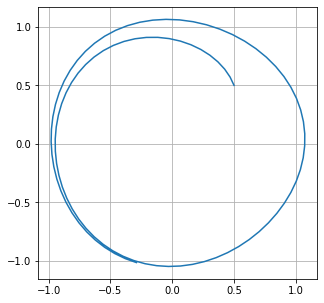

In [77]:
# Visualize vector field
from torch_vector_field import vector_field, utilities, plotting

class TorchToNumpyVectorFieldWrapper(vector_field.VectorField):
    def __init__(self, f: nn.Module):
        self.f = f 
    
    def get_gradient(self, x):
        x_t = torch.from_numpy(x.astype(np.float32))
        if hasattr(self.f, "device"): 
            x_t = x_t.to(self.f.device)
        with torch.no_grad():
            p_t = self.f(x_t)
        return p_t.detach().cpu().numpy().astype(np.float64)

net = build_net()
net_wrapped = TorchToNumpyVectorFieldWrapper(net)
h = utilities.simulate_trajectory(
    net_wrapped, 
    np.array([0.5, 0.5]),
    step_size=0.1, 
    num_iters = 100,
    grad_clip=1,
    ascending=True
)
plotting.plot_histories([h], figsize=(5,5))

## 2 - Define Training Procedure

### 2.1 - Construct Training Dataset

Construct trajectories over time

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_adjoint = False 

if use_adjoint: 
    from torchdiffeq import odeint_adjoint as odeint
else: 
    from torchdiffeq import odeint

class VanDerPol(nn.Module):
    """Return Van Der Pol vector field"""
    def __init__(self, mu=3):
        super(VanDerPol, self).__init__()
        self.mu = mu

    def forward(self, t, x):
        # VDP system dynamics are not time-varying
        del t

        x1, x2 = x[...,0], x[...,1]
        dx1 = x2
        dx2 = self.mu * (1 - x1 ** 2) * x2 - x1
        dx = torch.stack([dx1, dx2], axis=-1)
        return dx

def construct_dataset(data_size = 1024, device = device):
    x0 = torch.tensor(
        [2.0, 0.]
    ).to(device)
    t = torch.linspace(0., 25., data_size).to(device)

    with torch.no_grad():
        x = odeint(VanDerPol(), x0, t, method='dopri5')

    return x0, t, x

all_x0, all_t, all_x = construct_dataset()
# Sanity check dataset
print(all_x0.shape, all_t.shape, all_x.shape)

torch.Size([2]) torch.Size([1024]) torch.Size([1024, 2])


Sanity check dataset

In [59]:
def get_batch(x0, t, x, data_size = 1024, batch_size = 128, batch_time = 16, device=device):
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = x[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_x = torch.stack([x[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_x0.to(device), batch_t.to(device), batch_x.to(device)

# Sanity check batch function
batch_x0, batch_t, batch_x = get_batch(all_x0, all_t, all_x)
print(batch_x0.shape, batch_t.shape, batch_x.shape)


torch.Size([128, 2]) torch.Size([16]) torch.Size([16, 128, 2])


### 2.2 - Define Training Loop

Adapted from https://github.com/rtqichen/torchdiffeq/blob/master/examples/ode_demo.py

In [60]:
import time
import torch.optim as optim

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

def eval_model(
    model,
    x0, t, x
):
    with torch.no_grad():
        pred_x = odeint(model, x0, t)
        loss = torch.mean(torch.abs(pred_x - x))
    return loss

def train_model(model,
    batch_fn,
    num_iters = 2000, 
    test_freq = -1,
    print_freq = 20,
):  
    optimizer = optim.SGD(model.parameters(), lr=1e-3)
    start = time.time()
    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)
    end = start

    for itr in range(1, num_iters + 1):
        optimizer.zero_grad()
        x0, t, x = batch_fn()
        pred_x = odeint(model, x0, t).to(device)
        loss = torch.mean(torch.abs(pred_x - x))
        loss.backward()
        optimizer.step()

        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

        if itr % print_freq == 0:
            print('Iter {:04d} | Avg Loss {:.6f} | Avg Iter Time {:.2f}'.format(itr, loss_meter.val, time_meter.val))

        if test_freq > 0 and itr % test_freq == 0:
            loss = eval_model(model, all_x0, all_t, all_x)
            curr = time.time()
            time_elapsed = curr - start
            print('Iter {:04d} | Total Loss {:.6f} | Time Elapsed {:.2f}'.format(itr, loss.item(), time_elapsed))

        end = time.time()

In [61]:
# Sanity check training loop on simple baseline model
baseline_model = nn.Sequential(
    nn.Linear(2, 8), 
    nn.ELU(),
    nn.Linear(8, 2)
).to(device)
baseline_model = TimeWrapper(baseline_model)
batch_fn = lambda: get_batch(all_x0, all_t, all_x)
train_model(baseline_model, batch_fn, num_iters=2, print_freq=1)

Iter 0001 | Avg Loss 0.339669 | Avg Iter Time 0.30
Iter 0002 | Avg Loss 0.312665 | Avg Iter Time 0.29


In [62]:
# Sanity check training loop on full model for 1 iter
model = TimeWrapper(net)

batch_fn = lambda: get_batch(all_x0, all_t, all_x)
train_model(model, batch_fn, num_iters = 1, print_freq = 1)

Iter 0001 | Avg Loss 0.482249 | Avg Iter Time 3.35


## 3 - Experiments

In [64]:
# Sanity check training loop on simple baseline model
baseline_model = nn.Sequential(
    nn.Linear(2, 8), 
    nn.ELU(),
    nn.Linear(8, 2)
).to(device)
baseline_model = TimeWrapper(baseline_model)
batch_fn = lambda: get_batch(all_x0, all_t, all_x)
train_model(baseline_model, batch_fn, num_iters=100, print_freq = 10)
eval_model(baseline_model, all_x0, all_t, all_x)

Iter 0010 | Avg Loss 0.247961 | Avg Iter Time 0.25
Iter 0020 | Avg Loss 0.195889 | Avg Iter Time 0.25
Iter 0030 | Avg Loss 0.283478 | Avg Iter Time 0.25
Iter 0040 | Avg Loss 0.288999 | Avg Iter Time 0.27
Iter 0050 | Avg Loss 0.222740 | Avg Iter Time 0.29
Iter 0060 | Avg Loss 0.218783 | Avg Iter Time 0.26
Iter 0070 | Avg Loss 0.304464 | Avg Iter Time 0.29
Iter 0080 | Avg Loss 0.303862 | Avg Iter Time 0.29
Iter 0090 | Avg Loss 0.265350 | Avg Iter Time 0.29
Iter 0100 | Avg Loss 0.278629 | Avg Iter Time 0.31


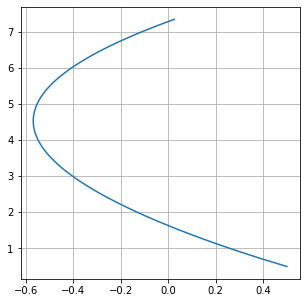

In [73]:
baseline_v = baseline_model.v 
baseline_v.to('cpu')
baseline_model_wrapped = TorchToNumpyVectorFieldWrapper(baseline_v)
h = utilities.simulate_trajectory(
    baseline_model_wrapped, 
    np.array([0.5, 0.5]),
    step_size=0.1, 
    num_iters = 100,
    grad_clip=1,
    ascending=True
)
plotting.plot_histories([h], figsize=(5,5))

In [71]:
net = build_net()
model = TimeWrapper(net)

batch_fn = lambda: get_batch(all_x0, all_t, all_x)
train_model(model, batch_fn, num_iters = 100, print_freq = 10)

Iter 0010 | Avg Loss 0.398780 | Avg Iter Time 3.00
Iter 0020 | Avg Loss 0.362709 | Avg Iter Time 2.91
Iter 0030 | Avg Loss 0.444711 | Avg Iter Time 3.05
Iter 0040 | Avg Loss 0.389900 | Avg Iter Time 2.87
Iter 0050 | Avg Loss 0.385500 | Avg Iter Time 2.66
Iter 0060 | Avg Loss 0.393663 | Avg Iter Time 2.35
Iter 0070 | Avg Loss 0.458770 | Avg Iter Time 2.51
Iter 0080 | Avg Loss 0.437301 | Avg Iter Time 2.62
Iter 0090 | Avg Loss 0.435102 | Avg Iter Time 2.39
Iter 0100 | Avg Loss 0.470761 | Avg Iter Time 3.20


In [86]:
model_v = model.v

class TorchToNumpyVectorFieldWrapper(vector_field.VectorField):
    def __init__(self, f: nn.Module):
        self.f = f 
    
    def get_gradient(self, x):
        x_t = torch.from_numpy(x.astype(np.float32))
        x_t = x_t.to(self.f.device)
        with torch.no_grad():
            p_t = self.f(x_t)
        return p_t.detach().cpu().numpy().astype(np.float64)

model_wrapped = TorchToNumpyVectorFieldWrapper(model_v)
h = utilities.simulate_trajectory(
    model_wrapped, 
    np.array([0.5, 0.5]),
    step_size=0.1, 
    num_iters = 100,
    grad_clip=1,
    ascending=True
)
plotting.plot_histories([h], figsize=(5,5))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat in method wrapper_addmv_)